In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ---------------------------
# 1. Load and Preprocess Metadata
# ---------------------------
CSV_PATH = 'cleaned_augmented_dataset.csv'
df = pd.read_csv(CSV_PATH)

# Optional: Print sample of the data
print("Sample of cleaned_augmented_dataset.csv:")
print(df.head())

# Convert Age column to numeric (if not already)
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df = df[df['Age'].notna()]

# Scale Age values to [0,1] for better training dynamics
scaler = MinMaxScaler()
df['Age_scaled'] = scaler.fit_transform(df[['Age']])

# ---------------------------
# 2. Set Up Data Generators
# ---------------------------
# Define parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 20

# Use ImageDataGenerator for augmentation during training; note that your augmented
# images are already in the CSV under the "Image" column (with full relative paths)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,      # 20% for validation
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# If your CSV's "Image" column contains full relative paths like
# "artifact_dataset/augmented_images/coin/457172_aug_0.jpg" then directory='' works.
# Otherwise, adjust directory accordingly.
TRAIN_DIR = ''  

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col="Image",
    y_col="Age_scaled",
    directory=TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    subset="training",
    class_mode='raw'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col="Image",
    y_col="Age_scaled",
    directory=TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    subset="validation",
    class_mode='raw'
)

# ---------------------------
# 3. Build the Model
# ---------------------------
# Use ResNet50 as the base model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
# Single output neuron for regression (predicting scaled Age)
predictions = Dense(1, activation='linear')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers initially
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='mean_squared_error',
              metrics=['mae'])

model.summary()

# ---------------------------
# 4. Train the Model
# ---------------------------
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), 
     # Save model in Keras format with .keras extension as required.
    ModelCheckpoint("final_artifact_date_model.keras", monitor='val_loss', save_best_only=True)
]
# Initial training with frozen base model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Fine-tuning: Unfreeze the last 20 layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='mean_squared_error',
              metrics=['mae'])

history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

# ---------------------------
# 5. Save the Final Model
# ---------------------------
model.save("final_artifact_date_model.keras")
print("Training complete. Final image-only model saved as final_artifact_date_model.keras")

# ---------------------------
# 6. (Optional) Save the Scaler for Inverse Transformations
# ---------------------------
import pickle
with open("age_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("Scaler saved as age_scaler.pkl")


Sample of cleaned_augmented_dataset.csv:
  ArtifactType         Name  \
0         coin  Coin Weight   
1         coin  Coin Weight   
2         coin         Coin   
3         coin         Coin   
4         coin         Coin   

                                               Image     Age  
0  artifact_dataset\augmented_images\coin\453551_...  1149.5  
1  artifact_dataset\augmented_images\coin\443187_...  1099.5  
2  artifact_dataset\augmented_images\coin\457636_...   899.5  
3            artifact_dataset/images/coin/457172.jpg   973.0  
4  artifact_dataset\augmented_images\coin\457603_...   815.0  
Found 4445 validated image filenames.
Found 1111 validated image filenames.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20


C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


139/139 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - loss: 1.3350 - mae: 0.9255 - val_loss: 0.0424 - val_mae: 0.1590
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - loss: 0.5265 - mae: 0.5806 - val_loss: 0.0382 - val_mae: 0.1494
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - loss: 0.3094 - mae: 0.4464 - val_loss: 0.0349 - val_mae: 0.1452
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - loss: 0.2055 - mae: 0.3623 - val_loss: 0.0339 - val_mae: 0.1450
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - loss: 0.1461 - mae: 0.3064 - val_loss: 0.0323 - val_mae: 0.1401
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - loss: 0.1080 - mae: 0.2617 - val_loss: 0.0314 - val_mae: 0.1380
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - loss: 0.0917 - mae: 0.2407 - val_loss: 0.0312 - val_mae: 0.1367
Epoch 8/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - loss: 0.0780 - mae: 0.2205 - val_loss: 0.0308 - val_mae: 0.1362
Epoch 9/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - loss

In [12]:
#evaluate
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import pickle

# Load the test dataset
test_df = pd.read_csv("test_dataset.csv")

# Ensure the Age column is numeric (if not already)
test_df['Age'] = pd.to_numeric(test_df['Age'], errors='coerce')
test_df = test_df.dropna(subset=['Age'])

# Create a data generator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image",     # This column should contain the full relative paths, e.g., "artifact_dataset/images/coin/457172.jpg"
    y_col="Age",
    directory='',      # Use '' if Image column already has relative paths from the project root
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

# Load your saved model and scaler
model = load_model("final_artifact_date_model.keras")
with open("age_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# Evaluate the model
results = model.evaluate(test_generator)
print("Test Loss:", results[0])
print("Test MAE:", results[1])


Found 186 validated image filenames.


C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 857032.4375 - mae: 905.4002
Test Loss: 865261.25
Test MAE: 904.4134521484375


In [16]:
import pandas as pd
df = pd.read_csv("test_dataset.csv")
print("Age statistics:", df["Age"].describe())


Age statistics: count     186.000000
mean      905.021505
std       218.125694
min       212.500000
25%       775.250000
50%       899.500000
75%       999.500000
max      1462.500000
Name: Age, dtype: float64


Predicted Age: 1031.2


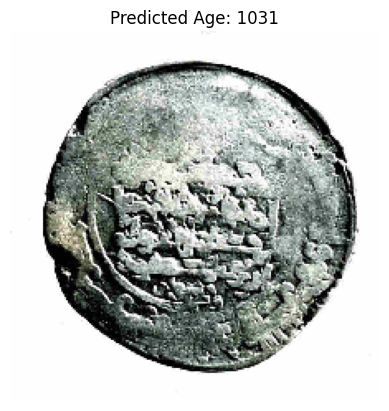

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load your model and scaler once
model = load_model("final_artifact_date_model.keras")
with open("age_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# Define a tf.function that takes a tensor as input and returns predictions.
@tf.function
def predict_on_image(img_tensor):
    return model(img_tensor)

def predict_image(img_path, scaler):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # shape: (1, 224, 224, 3)
    
    # Convert to a TensorFlow tensor
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    
    # Call the compiled function (avoids retracing in each call)
    pred_scaled = predict_on_image(img_tensor)
    
    # Convert predictions to NumPy and inverse-transform to get the actual age
    pred_scaled_np = pred_scaled.numpy()  # shape: (1, 1)
    pred_age = scaler.inverse_transform(pred_scaled_np)
    
    return pred_age[0][0], img

# Example usage:
sample_img_path = "artifact_dataset/images/coin/457172.jpg"  # Update as needed
predicted_age, img_disp = predict_image(sample_img_path, scaler)
print("Predicted Age:", predicted_age)

# Display image with prediction and (if available) true age
plt.imshow(np.array(img_disp).astype('uint8'))
plt.title(f"Predicted Age: {predicted_age:.0f}")
plt.axis('off')
plt.show()


True Age: 766.0
Predicted Age: 811


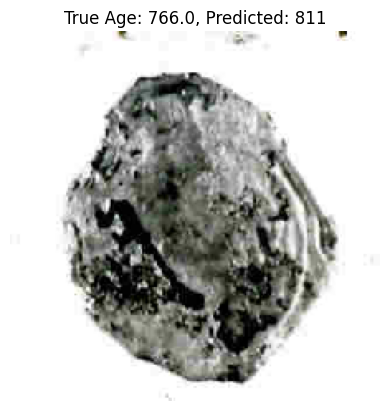

In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load your saved model and scaler
model = load_model("final_artifact_date_model.keras")
with open("age_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# Define a tf.function to avoid retracing
@tf.function
def predict_on_image(img_tensor):
    return model(img_tensor)

def predict_image(img_path, scaler):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # shape: (1, 224, 224, 3)
    
    # Convert to a TensorFlow tensor
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    
    # Get prediction using the compiled function
    pred_scaled = predict_on_image(img_tensor)
    
    # Convert predictions to NumPy array and inverse-transform to get actual age
    pred_scaled_np = pred_scaled.numpy()  # shape: (1, 1)
    pred_age = scaler.inverse_transform(pred_scaled_np)
    
    return pred_age[0][0], img

# Load your test CSV (should contain columns "Image" and "Age")
test_df = pd.read_csv("test_dataset.csv")

# Choose a sample row for evaluation (for example, the first row)
sample_row = test_df.iloc[0]
true_age = sample_row['Age']
sample_img_path = sample_row['Image']

# Get the predicted age for the sample image
predicted_age, img_disp = predict_image(sample_img_path, scaler)

print(f"True Age: {true_age}")
print(f"Predicted Age: {predicted_age:.0f}")

# Display the image with both true and predicted ages in the title
plt.imshow(np.array(img_disp).astype('uint8'))
plt.title(f"True Age: {true_age}, Predicted: {predicted_age:.0f}")
plt.axis('off')
plt.show()
